# Quickstart Tutorial

`multiswarm` is an MPI-parallelized implementation of Particle Swarm Optimization (PSO). PSO is a method of loss minimization which starts highly explorative, and slowly reduces search space as the particles slowly decelerate and gravitate towards their personal best, and eventually the global minimum.

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import multiswarm

## Example loss function:

The Ackley function: N-dimensional function with **many** local minima (roughly $10^N$ local minima for N dimensions, each with a range of $-5 < x_i < 5$). Therefore, this function is essentially impossible minimize with methods like gradient descent, unless you begin with an extremely good initial guess.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


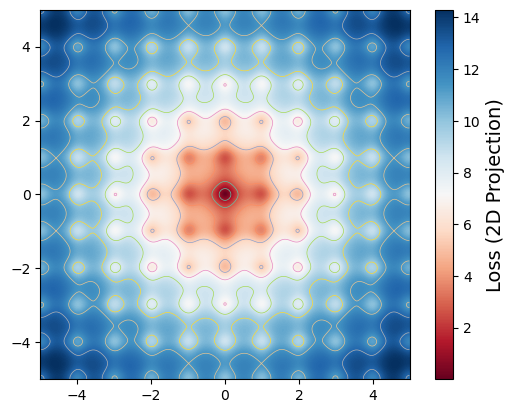

In [2]:
def ackley(x_array):
    a = 20 * jnp.exp(-0.2 * jnp.sqrt(0.5 * (jnp.sum(x_array**2, axis=0))))
    b = jnp.exp(0.5 * jnp.sum(jnp.cos(2*jnp.pi*x_array), axis=0))
    return 20 + jnp.e - a - b


def plot_ackley2d(extent=(-5, 5, -5, 5), res=0.01,
                  ax=None, add_cbar=True):
    if ax is None:
        ax = plt.gca()
    x = np.arange(*extent[:2], res)
    y = np.arange(*extent[2:], res)
    x, y = np.meshgrid(x, y)
    z = ackley(np.array([x, y]))
    im = ax.imshow(z, cmap="RdBu", extent=extent, origin="lower")

    ax.contour(x, y, z, np.linspace(1, z.max(), 10), linewidths=0.5,
               cmap=plt.matplotlib.cm.Set2)
    if add_cbar:
        plt.colorbar(im, ax=ax).set_label("Loss (2D Projection)", fontsize=14)

plot_ackley2d()

## Run PSO to minimize the loss

- Fit the 4-dimensional Ackley function
- Define search space from $-5 < x < 5$ for all 4 dimensions
- With default inertial/cognitive/social weights, I recommend using 100 particles and iterating for 100 steps

In [3]:
swarm = multiswarm.ParticleSwarm(nparticles=100, ndim=4, xlow=-5, xhigh=5)
results = swarm.run_pso(ackley, nsteps=100)

PSO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


## Get the minimum loss found

- With the `get_best_loss_and_params` convenience function, we see that the particle swarm has converged very closely upon the global minima at the origin [0, 0, 0, 0].

In [4]:
best_loss, best_params = multiswarm.get_best_loss_and_params(
    results["swarm_loss_history"], results["swarm_x_history"])
print("Best loss found =", best_loss)
print("at params =", best_params)

Best loss found = -4.6277704
at params = [0.00556334 0.00865068 0.00135516 0.00539218]


### Plot the best loss as a function of time step

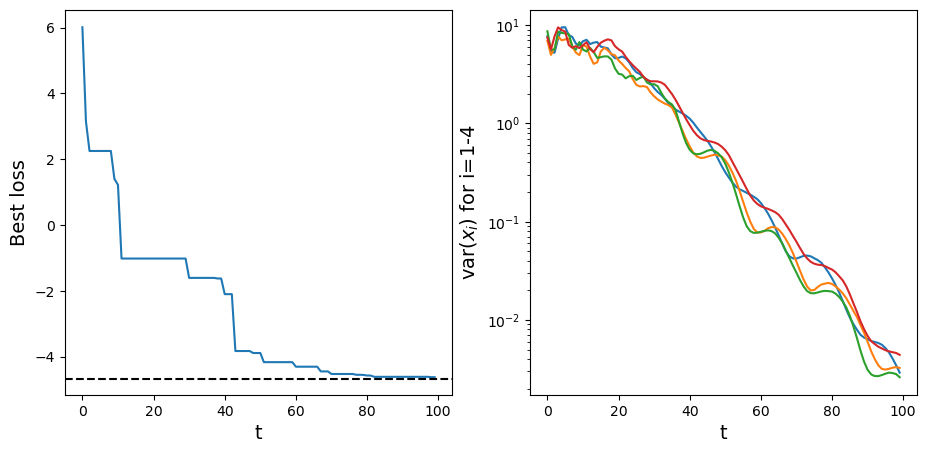

In [5]:
loss_histories = results["swarm_loss_history"]
pos_histories = results["swarm_x_history"]
best_loss_possible = ackley(np.zeros(pos_histories.shape[-1]))

var_histories = np.var(pos_histories, axis=1)
best_losses = np.min(loss_histories, axis=1)
best_losses = np.minimum.accumulate(best_losses)
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
axes[0].plot(best_losses, color="C0")
axes[0].axhline(best_loss_possible, color="k", ls="--")
axes[1].semilogy(var_histories)
axes[0].set_xlabel("t", fontsize=14)
axes[0].set_ylabel("Best loss", fontsize=14)
axes[1].set_xlabel("t", fontsize=14)
axes[1].set_ylabel("var($x_i$) for i=1-4", fontsize=14)
plt.show()

## The same thing, but parallel!

`multiswarm` automatically distributes particles across all available MPI ranks. To try this out, let's redo this exercise, but this time in the script `multiswarm-ackley-4d.py` which is copied below (this is essentially just copy-and-pasting everything we've done in this notebook):

```python
"""
multiswarm-ackley-4d.py
"""

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI

import multiswarm


def ackley(x_array):
    a = 20 * jnp.exp(-0.2 * jnp.sqrt(0.5 * (jnp.sum(x_array**2, axis=0))))
    b = jnp.exp(0.5 * jnp.sum(jnp.cos(2*jnp.pi*x_array), axis=0))
    return 20 + jnp.e - a - b


if __name__ == "__main__":
    swarm = multiswarm.ParticleSwarm(nparticles=100, ndim=4, xlow=-5, xhigh=5)
    results = swarm.run_pso(ackley, nsteps=100)

    best_loss, best_params = multiswarm.get_best_loss_and_params(
        results["swarm_loss_history"], results["swarm_x_history"])

    if not MPI.COMM_WORLD.rank:
        print("Best loss found =", best_loss)
        print("at params =", best_params)

        loss_histories = results["swarm_loss_history"]
        pos_histories = results["swarm_x_history"]
        best_loss_possible = ackley(np.zeros(pos_histories.shape[-1]))

        var_histories = np.var(pos_histories, axis=1)
        best_losses = np.min(loss_histories, axis=1)
        best_losses = np.minimum.accumulate(best_losses)
        fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
        axes[0].plot(best_losses, color="C0")
        axes[0].axhline(best_loss_possible, color="k", ls="--")
        axes[1].semilogy(var_histories)
        axes[0].set_xlabel("t", fontsize=14)
        axes[0].set_ylabel("Best loss", fontsize=14)
        axes[1].set_xlabel("t", fontsize=14)
        axes[1].set_ylabel("var($x_i$) for i=1-4", fontsize=14)
        plt.savefig("ackley-fit-results.png")
```

Now let's ru this with three MPI ranks (this will assign 33 particles per rank, except one which gets 34). Executing `mpiexec -n 3 python multiswarm-ackley-4d.py` yields the following results (with about a 2x speedup on my laptop):

```txt
PSO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]
Best loss found = -4.6522627
at params = [ 0.00065104 -0.0034627  -0.00270411 -0.00358401]
```

![Results plot](./ackley-fit-results.png)